# Entregable 3 de Optimización Determinista

## Integrantes:
- A01066843 - Facundo Bautista Barbera
- A01742811 - Valeria Garcia Hernandez
- A01285034 - Ana Sofia Nagao Alvarez
-  A01424351 - Azul Fernanda Paniagua Bucio
- A01424357 - Patricio Mourra Cossío

# Cargar Librerías

In [1]:
import math
import xml.etree.ElementTree as ET
import zipfile
import networkx as nx
import json

import matplotlib.pyplot as plt
import pandas as pd

# Cargar Datos

Para empezar el proceso de prueba, se necesitan cargar los puntos del mapa.
Este mapa se ha hecho en un software llamado GeoGebra, y se ha exportado a un archivo .ggb.
A continuación se extraerán los puntos del archivo .ggb y se guardarán en un archivo .csv.

_Nota: Si los archivos ya existen, no se volverán a crear._

In [2]:
INPUT_GGB = "data/raw/puntos.ggb"
DICTIONARY_JSON = "data/raw/dictionary.json"
OUTPUT_CSV = "data/processed/puntos.csv"
SCALED_CSV = "data/processed/puntos_escalados.csv"

def extract_points_from_ggb(ggb_file):
    """Extract point coordinates from a GeoGebra .ggb file."""
    points_dict = {}

    with zipfile.ZipFile(ggb_file, "r") as zip_ref:
        with zip_ref.open('geogebra.xml') as file:
            tree = ET.parse(file)
            root = tree.getroot()

            for element in root.iter('element'):
                if element.attrib.get('type') == 'point':
                    label = element.attrib.get('label', None)
                    coords = element.find('coords')
                    if label and coords is not None:
                        try:
                            x = float(coords.attrib.get('x', 'nan'))
                            y = float(coords.attrib.get('y', 'nan'))
                            points_dict[label] = (x, y)
                        except ValueError:
                            pass

    return points_dict

def rename_points(points_dict, dictionary_file):
    """Rename point labels based on dictionary.json."""
    with open(dictionary_file, 'r') as f:
        rename_dict = json.load(f)

    # Reverse mapping (values to keys) since keys are the new names
    reversed_dict = {v: k for k, v in rename_dict.items()}

    renamed_points = {reversed_dict.get(label, label): coords for label, coords in points_dict.items()}

    return renamed_points

def save_to_csv(points_dict, output_file):
    """Save points to CSV."""
    df = pd.DataFrame(points_dict.items(), columns=['Label', 'Coordinates'])
    df[['X', 'Y']] = pd.DataFrame(df['Coordinates'].tolist(), index=df.index)
    df = df.drop(columns=['Coordinates'])

    df.to_csv(output_file, index=False)
    print(f"Saved points to {output_file}")

def scale_points(points_dict, target_distance=100):
    """Scale points so that the distance between C and D is exactly target_distance and remove A, B, C, and D."""
    if 'C' not in points_dict or 'D' not in points_dict:
        raise ValueError("Points 'C' and 'D' must be present in the dataset for scaling.")

    xC, yC = points_dict['C']
    xD, yD = points_dict['D']
    current_distance = math.dist((xC, yC), (xD, yD))

    scale_factor = target_distance / current_distance

    # Find midpoint of C and D for scaling reference
    mid_x = (xC + xD) / 2.0
    mid_y = (yC + yD) / 2.0

    scaled_points = {}
    for label, (x, y) in points_dict.items():
        x_scaled = ((x - mid_x) * scale_factor) + mid_x
        y_scaled = ((y - mid_y) * scale_factor) + mid_y
        scaled_points[label] = (x_scaled, y_scaled)

    # Remove points A, B, C, and D
    for point in ['A', 'B', 'C', 'D']:
        scaled_points.pop(point, None)

    return scaled_points

# Step 1: Extract points from GGB
points = extract_points_from_ggb(INPUT_GGB)

# Step 2: Rename points based on dictionary.json
renamed_points = rename_points(points, DICTIONARY_JSON)

# Step 3: Save renamed points to puntos.csv
save_to_csv(renamed_points, OUTPUT_CSV)

# Step 4: Scale points and save to puntos_escalados.csv
scaled_points = scale_points(renamed_points)
save_to_csv(scaled_points, SCALED_CSV)

Saved points to data/processed/puntos.csv
Saved points to data/processed/puntos_escalados.csv


# Graficar Puntos

A continuación se graficarán los puntos extraídos del archivo .ggb.

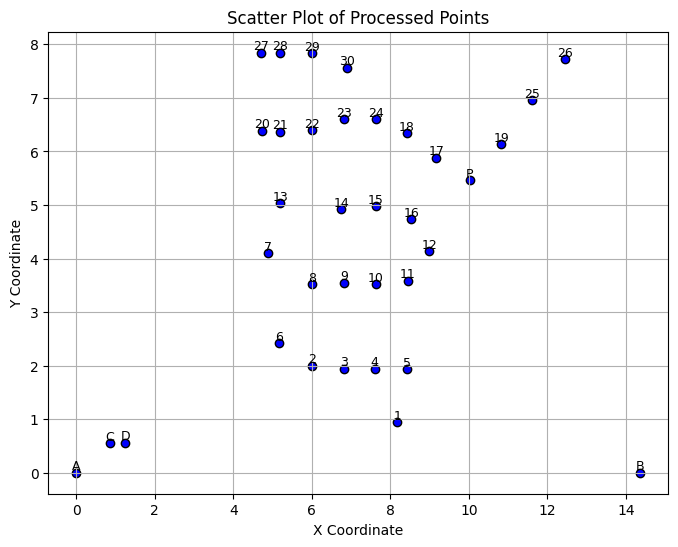

In [3]:
def plot_points(csv_file):
    df = pd.read_csv(csv_file)

    if not {'Label', 'X', 'Y'}.issubset(df.columns):
        raise ValueError("The CSV file must contain 'Label', 'X', and 'Y' columns.")

    plt.figure(figsize=(8, 6))
    plt.scatter(df["X"], df["Y"], color='blue', edgecolors='black')

    for _, row in df.iterrows():
        plt.text(row["X"], row["Y"], row["Label"], fontsize=9, ha='center', va='bottom')

    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title("Scatter Plot of Processed Points")
    plt.grid(True)
    plt.show()

plot_points("data/processed/puntos.csv")  # Use puntos.csv instead of puntos_escalados.csv

# Obtener Distancias entre Puntos

A continuación se calcularán las distancias entre los puntos y se guardarán en un archivo .csv.

In [4]:
def compute_distances(csv_file):
    df = pd.read_csv(csv_file)

    if not {'Label', 'X', 'Y'}.issubset(df.columns):
        raise ValueError("The CSV file must contain 'Label', 'X', and 'Y' columns.")

    labels = df["Label"].values
    coords = df[["X", "Y"]].values
    num_points = len(labels)

    distance_matrix = pd.DataFrame(index=labels, columns=labels)
    for i in range(num_points):
        for j in range(num_points):
            distance_matrix.iloc[i, j] = math.dist(coords[i], coords[j])

    distance_matrix.to_csv("data/processed/matriz_distancias.csv")

    return distance_matrix

distances = compute_distances("data/processed/puntos_escalados.csv")

# Crear grafo de distancias

A continuación se creará un grafo con las distancias entre los puntos.

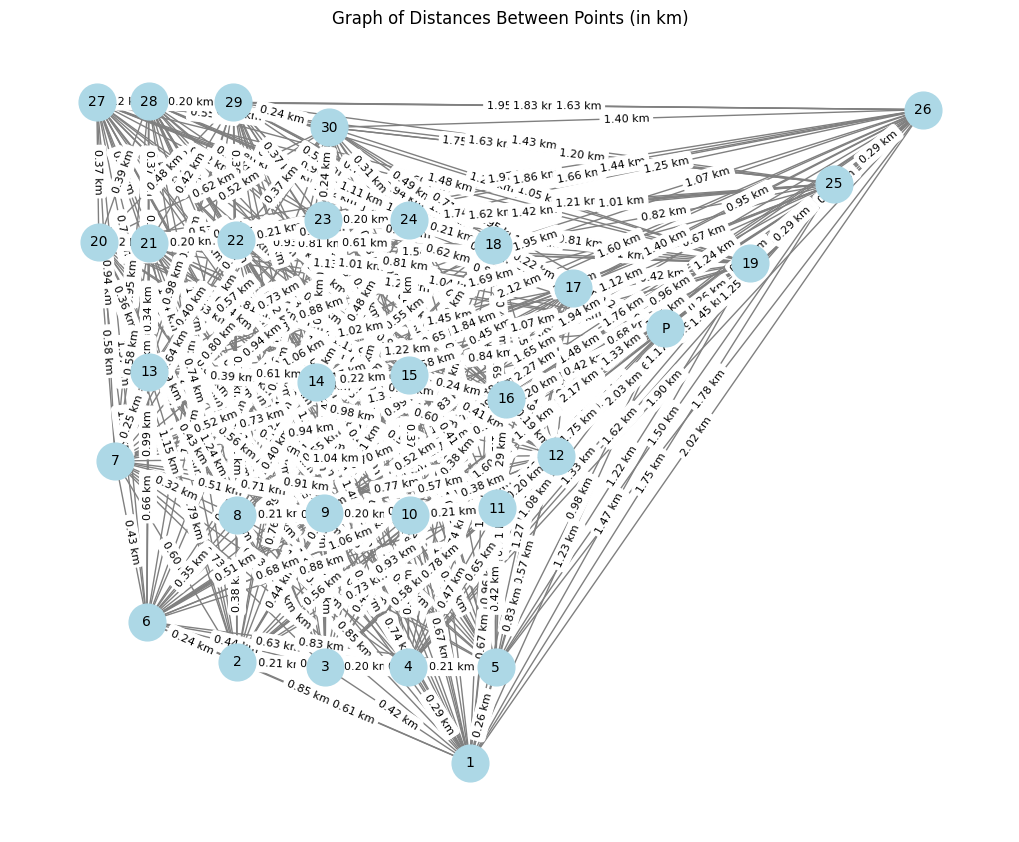

In [5]:
def plot_distance_graph(csv_file):
    df_distances = pd.read_csv(csv_file, index_col=0)

    df_distances_km = df_distances / 1000

    G = nx.Graph()

    labels = df_distances_km.index
    for label in labels:
        G.add_node(label)

    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            if i < j:
                distance_km = df_distances_km.iloc[i, j]
                G.add_edge(label1, label2, weight=distance_km)

    pos = {node: (-x, y) for node, (x, y) in nx.kamada_kawai_layout(G).items()}

    plt.figure(figsize=(10, 8))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)

    edge_labels = {(label1, label2): f"{df_distances_km.loc[label1, label2]:.2f} km"
                   for label1, label2 in G.edges}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title("Graph of Distances Between Points (in km)")
    plt.show()

plot_distance_graph("data/processed/matriz_distancias.csv")

# Crear polígonos

A continuación se creará un polígono con los puntos extraídos del archivo .ggb.

Se crearan:
- 5 polígonos con 15 nodos aleatorios (small)
- 5 polígonos con 20 nodos aleatorios (medium)
- 5 polígonos con 25 nodos aleatorios (large)

Los polígonos son guardados en archivos .csv.

In [6]:
def generate_random_polygons(csv_file, cluster_size, num_variations):
    df = pd.read_csv(csv_file)

    if not {'Label', 'X', 'Y'}.issubset(df.columns):
        raise ValueError("The CSV file must contain 'Label', 'X', and 'Y' columns.")

    polygons = []
    for _ in range(num_variations):
        sampled_df = df.sample(n=cluster_size, replace=False)
        polygons.append(sampled_df)

    return polygons


def save_polygons_to_csv(polygons, output_dir, prefix):
    import os
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for i, polygon in enumerate(polygons):
        output_file = f"{output_dir}/{prefix}_{i+1}.csv"
        polygon.to_csv(output_file, index=False)
        print(f"Saved: {output_file}")


small_polygons = generate_random_polygons("data/processed/puntos_escalados.csv", 15, 5)
save_polygons_to_csv(small_polygons, "data/processed/small", "small")

medium_polygons = generate_random_polygons("data/processed/puntos_escalados.csv", 20, 5)
save_polygons_to_csv(medium_polygons, "data/processed/medium", "medium")

large_polygons = generate_random_polygons("data/processed/puntos_escalados.csv", 25, 5)
save_polygons_to_csv(large_polygons, "data/processed/big", "big")

Saved: data/processed/small/small_1.csv
Saved: data/processed/small/small_2.csv
Saved: data/processed/small/small_3.csv
Saved: data/processed/small/small_4.csv
Saved: data/processed/small/small_5.csv
Saved: data/processed/medium/medium_1.csv
Saved: data/processed/medium/medium_2.csv
Saved: data/processed/medium/medium_3.csv
Saved: data/processed/medium/medium_4.csv
Saved: data/processed/medium/medium_5.csv
Saved: data/processed/big/big_1.csv
Saved: data/processed/big/big_2.csv
Saved: data/processed/big/big_3.csv
Saved: data/processed/big/big_4.csv
Saved: data/processed/big/big_5.csv
